# Setup

## Imports

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne 
from matplotlib.pyplot import cm
from scipy.fftpack import fft

import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import json
import os
import yaml
import keras_tuner as kt

# from fdasrsf import fPCA, time_warping, fdawarp, fdahpcafd
# Article about fPCA here: https://towardsdatascience.com/beyond-classic-pca-functional-principal-components-analysis-fpca-applied-to-time-series-with-python-914c058f47a0

In [35]:
from numba import cuda

cuda.select_device(0)
cuda.close()
cuda.select_device(1)
cuda.close()

## Constants

In [57]:
sub_dirs = ['8hz_20trials/','9hz_20trials/','10hz_20trials/',
            '11hz_10trials_run1/','11hz_10trials_run2/',
            '12hz_10trials_run1/','12hz_10trials_run2/',
            '12.6hz_10trials_run1/','12.6hz_10trials_run2/',
            '13hz_10trials_run1/','13hz_10trials_run2/',
            '14hz_10trials_run1/','14hz_10trials_run2/',
            '15hz_10trials_run1/','15hz_10trials_run2/']

num_targets = 36
sampling_frequency = 300
isi_duration = 0.750  # s
stimulus_duration = 5.000 # s
num_trial_per_target = 20
channels = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3']
num_channels = len(channels)
timepoints_stimulus_duration = int(stimulus_duration * sampling_frequency)  # 1500
timepoints_isi = int(sampling_frequency * isi_duration)
timepoints_per_trial = int((isi_duration + stimulus_duration) * sampling_frequency)

num_gpus = len(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data

In [5]:
def load_data_temp_function(eeg, meta, classes):
    """
    Return
        (
    """
    trials = meta[1:,:2]
    times = meta[:,2]
    times = (times - times[0])[1:]
    eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:timepoints_per_trial].T for t in times])[:,:,timepoints_isi:]
    eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

Aggregate the different recording (trials, single_recording_target, channels, timepoints) to (trials, num_targets, channels, timepoints)
Assuming each recording comes with 4 targets 

In [6]:
eeg_all = np.zeros((num_trial_per_target, num_targets, num_channels, timepoints_stimulus_duration))
trial_all = []  # (num_targets, 1 + 1), freq and phase
recording_count = 0
for i_dir,sub_dir in enumerate(sub_dirs):
    if sub_dir[-2] == '2':
        continue
    data_path = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)  # (4, 2), 4 targets, each target has a freq and a phase
    eeg = load_data_temp_function(eeg, meta, classes)
    if sub_dir not in ['8hz_20trials/','9hz_20trials/','10hz_20trials/']:
        if sub_dir[-2] == '1' and i_dir+1 < len(sub_dirs):
            sub_dir2 = sub_dirs[i_dir+1]
            data_path2 = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir2
            eeg2 = pd.read_csv(data_path2 + 'eeg.csv').astype(float)
            meta2 = np.loadtxt(data_path2 + 'meta.csv', delimiter=',', dtype=float)
            trials2 = meta2[1:,:2]
            eeg2 = load_data_temp_function(eeg2,meta2,classes)
            eeg = np.vstack((eeg,eeg2))
    trial_all.append(classes.tolist())
    eeg_all[:, recording_count:recording_count + 4] = eeg
    recording_count += 4
trial_all = np.array(trial_all).reshape([-1, 2])  

In [7]:
trial_all.shape, eeg_all.shape

((36, 2), (20, 36, 7, 1500))

Create a lookup table from (freq, phase) to 0, 1, ..., num_targets - 1

In [8]:
target_idx_tab = {}
target_idx_tab = {(freq, phase): i for i, (freq, phase) in enumerate(trial_all)}
assert len(target_idx_tab.keys()) == num_targets
target_idx_tab

{(8.0, 0.0): 0,
 (8.0, 0.5): 1,
 (8.0, 1.0): 2,
 (8.0, 1.5): 3,
 (9.0, 0.0): 4,
 (9.0, 0.5): 5,
 (9.0, 1.0): 6,
 (9.0, 1.5): 7,
 (10.0, 0.0): 8,
 (10.0, 0.5): 9,
 (10.0, 1.0): 10,
 (10.0, 1.5): 11,
 (11.0, 0.0): 12,
 (11.0, 0.5): 13,
 (11.0, 1.0): 14,
 (11.0, 1.5): 15,
 (12.0, 0.0): 16,
 (12.0, 0.5): 17,
 (12.0, 1.0): 18,
 (12.0, 1.5): 19,
 (12.6, 0.25): 20,
 (12.6, 0.75): 21,
 (12.6, 1.25): 22,
 (12.6, 1.75): 23,
 (13.0, 0.0): 24,
 (13.0, 0.5): 25,
 (13.0, 1.0): 26,
 (13.0, 1.5): 27,
 (14.0, 0.0): 28,
 (14.0, 0.5): 29,
 (14.0, 1.0): 30,
 (14.0, 1.5): 31,
 (15.0, 0.25): 32,
 (15.0, 0.75): 33,
 (15.0, 1.25): 34,
 (15.0, 1.75): 35}

## PCA Analysis
We'll use PCA to see the variance of each recording channels and seek to reduce the number of recording channels
Refer to https://medium.com/@ansjin/dimensionality-reduction-using-pca-on-multivariate-timeseries-data-b5cc07238dc4 for more details

Before applying PCA, we first have to concatenate all the trials and targets and swap channel and timepoints such that the final dimension is (timepoints * num_targets * trials, channels)

In [9]:
def highlight_abs_max(s):
    is_max = abs(s) == abs(s).max()
    return ['background-color: green' if v else '' for v in is_max]
def highlight_abs_min(s):
    is_min = abs(s) == abs(s).min()
    return ['background-color: red' if v else '' for v in is_min]
# df.T.style.apply(highlight_abs_max).apply(highlight_abs_min)

In [10]:
eeg_all_flatten = eeg_all.transpose(0, 1, 3, 2)
eeg_all_flatten = eeg_all_flatten.reshape((-1, num_channels))
assert eeg_all_flatten.shape == (num_targets * timepoints_stimulus_duration * num_trial_per_target, num_channels)

In [11]:
pca = PCA(n_components=num_channels)
eeg_all_pca = pca.fit_transform(eeg_all_flatten)
n_pc = eeg_all_pca.shape[-1]
pc_channels = [f'PC{i}' for i in range(n_pc)]

# reshape eeg_all_pca to ((num_trial_per_target, num_targets, num_pc, timepoints_stimulus_duration)
eeg_all_pca = eeg_all_pca.reshape((num_trial_per_target, num_targets, timepoints_stimulus_duration, n_pc))
eeg_all_pca = eeg_all_pca.transpose(0, 1, 3, 2)
assert eeg_all_pca.shape == (num_trial_per_target, num_targets, n_pc, timepoints_stimulus_duration)

Determine most salient channels based on how much the channels explains each PC

In [12]:
df = pd.DataFrame(pca.components_, columns=channels)
df.index = pc_channels
df.T.style.apply(highlight_abs_max)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
Pz,0.557721,-0.107301,-0.500188,-0.347649,0.288800,-0.397921,-0.254245
F4,0.159199,-0.403695,0.329867,0.387409,0.006609,-0.648560,0.363476
C4,0.231443,-0.355958,0.012960,0.513357,-0.239999,0.211718,-0.673499
P4,0.403689,-0.246262,-0.357462,0.198585,-0.024779,0.516555,0.584579
P3,0.576243,0.701982,0.336767,0.240952,0.056250,0.022657,0.004227
C3,0.291381,-0.123570,0.250410,-0.509858,-0.758084,-0.009061,0.048925
F3,0.173535,-0.360717,0.580462,-0.328739,0.529606,0.329819,-0.074166


[0.70664017 0.11646218 0.08316885 0.04275267 0.02502631 0.01670521
 0.00924462]
[0.70664017 0.82310235 0.9062712  0.94902387 0.97405017 0.99075538
 1.        ]


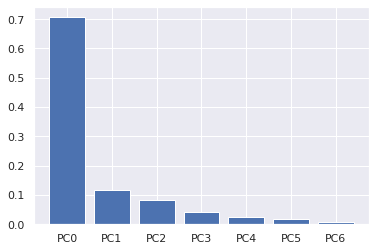

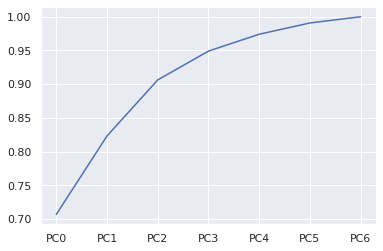

In [13]:
plt.figure()
plt.bar(pc_channels, pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pc_channels, np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_))

### Fit based on MLE

In [14]:
# scaler = StandardScaler()
# eeg_all_flatten = scaler.fit_transform(eeg_all_flatten)

pca = PCA(n_components='mle')
eeg_all_pca = pca.fit_transform(eeg_all_flatten)
n_pc = eeg_all_pca.shape[-1]
pc_channels = [f'PC{i}' for i in range(n_pc)]

# reshape eeg_all_pca to ((num_trial_per_target, num_targets, num_pc, timepoints_stimulus_duration)
eeg_all_pca = eeg_all_pca.reshape((num_trial_per_target, num_targets, timepoints_stimulus_duration, n_pc))
eeg_all_pca = eeg_all_pca.transpose(0, 1, 3, 2)
assert eeg_all_pca.shape == (num_trial_per_target, num_targets, n_pc, timepoints_stimulus_duration)

Determine most salient channels based on how much the channels explains each PC

In [15]:
df = pd.DataFrame(pca.components_, columns=channels)
df.index = pc_channels
df.T.style.apply(highlight_abs_max)

,PC0,PC1,PC2,PC3,PC4,PC5
Pz,0.557721,-0.107301,-0.500188,-0.347649,0.288800,-0.397921
F4,0.159199,-0.403695,0.329867,0.387409,0.006609,-0.648560
C4,0.231443,-0.355958,0.012960,0.513357,-0.239999,0.211718
P4,0.403689,-0.246262,-0.357462,0.198585,-0.024779,0.516555
P3,0.576243,0.701982,0.336767,0.240952,0.056250,0.022657
C3,0.291381,-0.123570,0.250410,-0.509858,-0.758084,-0.009061
F3,0.173535,-0.360717,0.580462,-0.328739,0.529606,0.329819


[0.70664017 0.11646218 0.08316885 0.04275267 0.02502631 0.01670521]
[0.70664017 0.82310235 0.9062712  0.94902387 0.97405017 0.99075538]


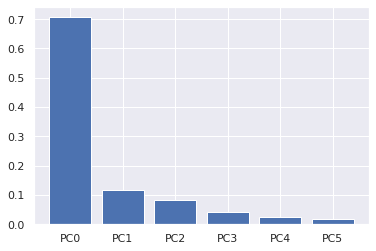

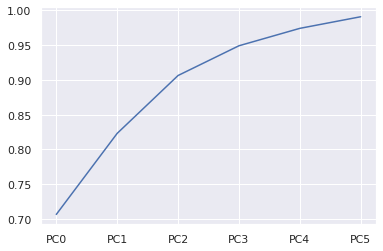

In [16]:
plt.figure()
plt.bar(pc_channels, pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pc_channels, np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_))

Seems like most channels are contributing 

### Compare PCA PSD v.s. Original PSD

Original

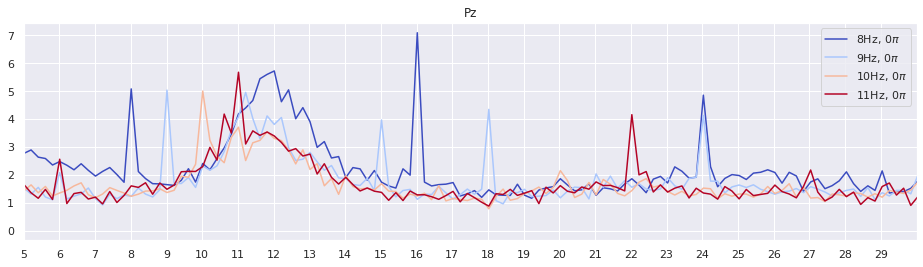

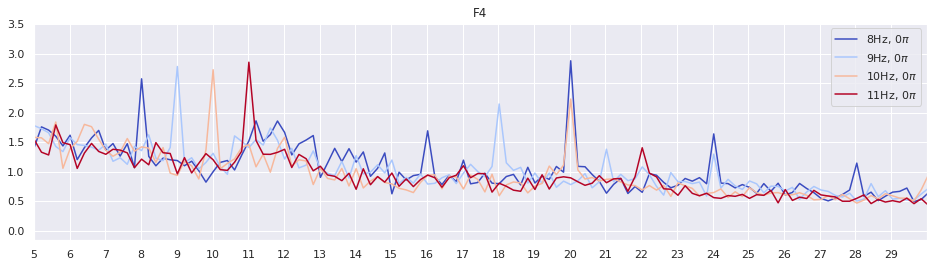

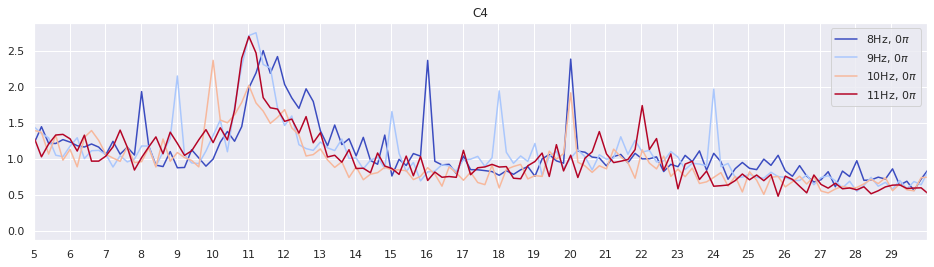

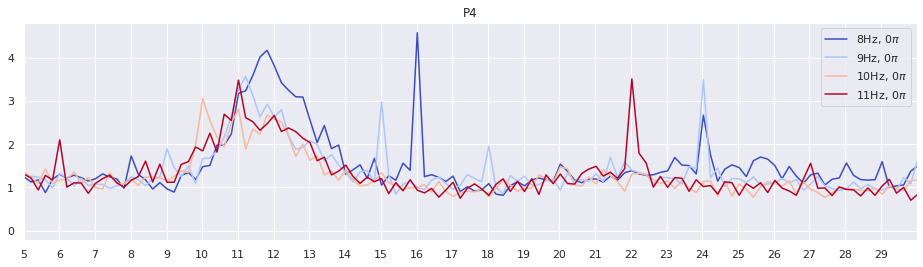

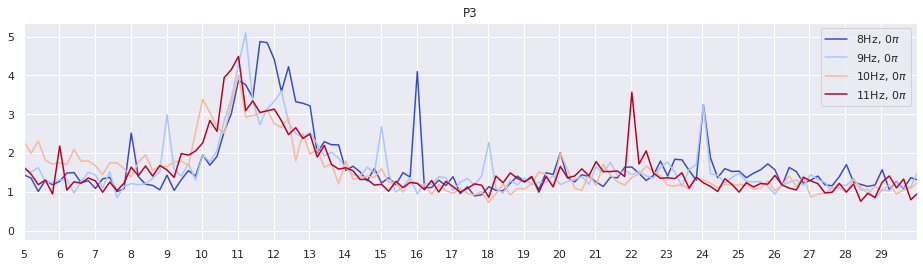

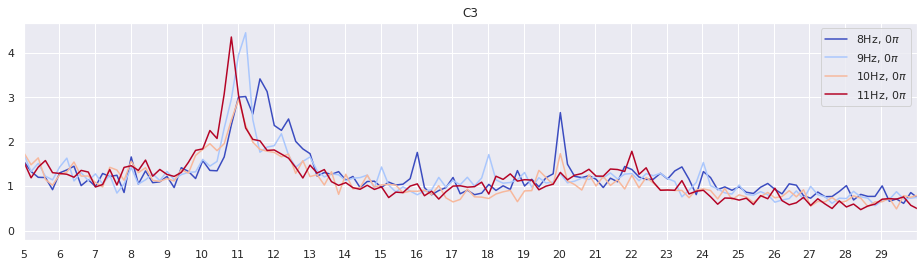

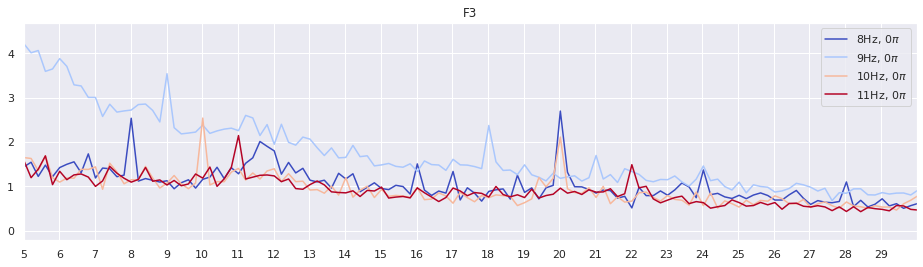

In [17]:
freqs = np.linspace(0.0, sampling_frequency / 2, timepoints_stimulus_duration // 2)
psd = 2/(timepoints_stimulus_duration / 2)*np.abs(fft(eeg_all)[:,:,:,:timepoints_stimulus_duration // 2])
psd = psd.mean(axis=0) # take the mean psd across trials
# visualize some of the targets on frequency domain
target_interest = [(8, 0), (9, 0), (10, 0), (11, 0)]
channel_interest = channels
for channel in channel_interest:
    plt.figure(figsize=(16, 4))
    ax = plt.subplot()
    ax.set_xlim(5, 30)
    colors=cm.coolwarm(np.linspace(0,1, len(target_interest)))
    for i, (freq, phase) in enumerate(target_interest):
        sns.lineplot(x=freqs, y=psd[target_idx_tab[(freq, phase)], channels.index(channel),:], ax=ax, label=f'{freq}Hz, {phase}$\pi$', color=colors[i])
    plt.title(channel)
    plt.xticks(range(5,30));

PCA

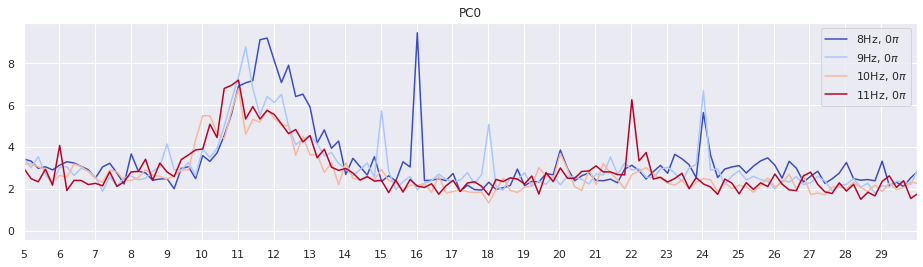

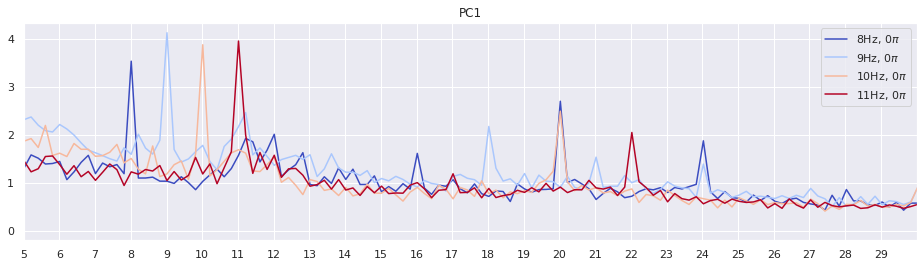

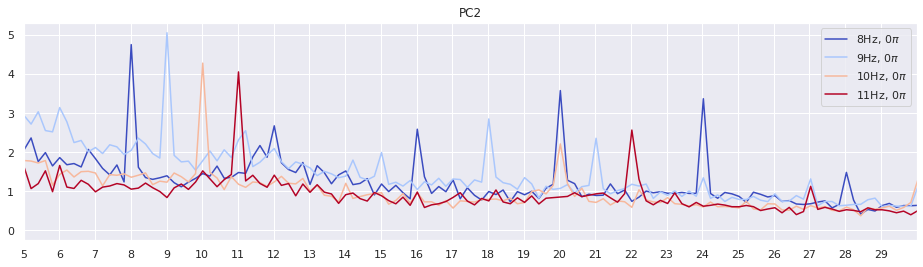

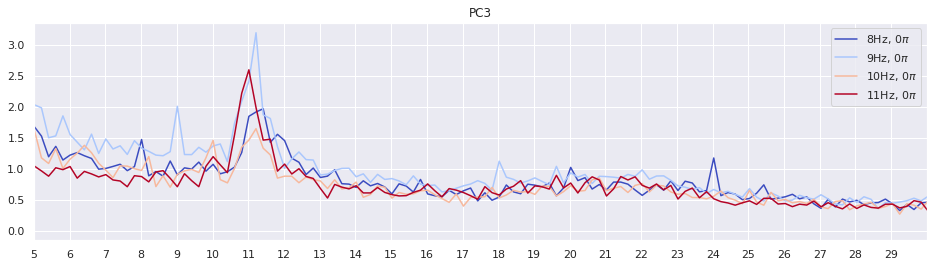

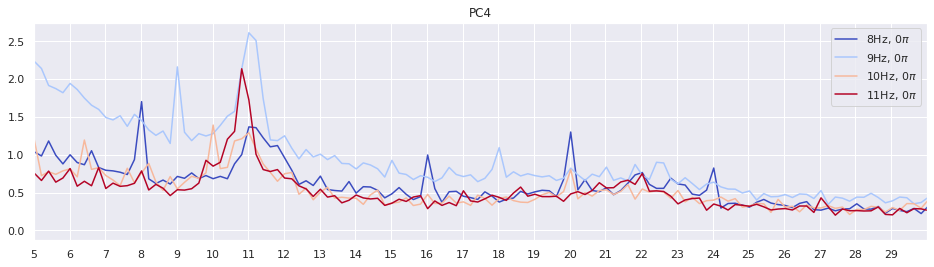

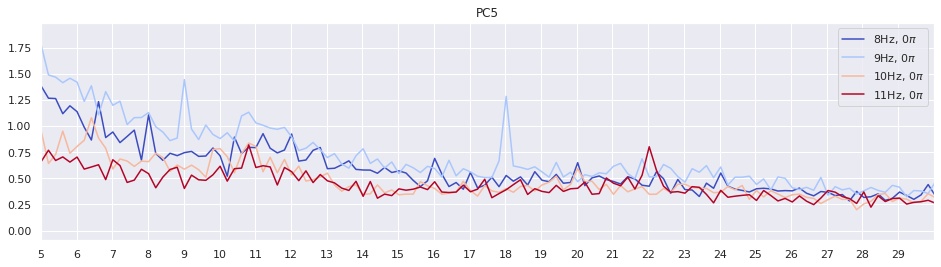

In [18]:
freqs = np.linspace(0.0, sampling_frequency / 2, timepoints_stimulus_duration // 2)
psd = 2/(timepoints_stimulus_duration / 2)*np.abs(fft(eeg_all_pca)[:,:,:,:timepoints_stimulus_duration // 2])
psd = psd.mean(axis=0) # take the mean psd across sessions
# visualize some of the targets on frequency domain
target_interest = [(8, 0), (9, 0), (10, 0), (11, 0)]
channel_interest = pc_channels
for channel in channel_interest:
    plt.figure(figsize=(16, 4))
    ax = plt.subplot()
    ax.set_xlim(5, 30)
    colors=cm.coolwarm(np.linspace(0,1, len(target_interest)))
    for i, (freq, phase) in enumerate(target_interest):
        sns.lineplot(x=freqs, y=psd[target_idx_tab[(freq, phase)], pc_channels.index(channel),:], ax=ax, label=f'{freq}Hz, {phase}$\pi$', color=colors[i])
    plt.title(channel)
    plt.xticks(range(5,30));

# Models

## EEGNet

In [54]:
hpspace = {
    'learningRate': {
        'type': 'float',
        'min_value': 6e-4,
        'max_value': 1e-3,
        'sampling': 'log'
    },
    'batchSize': {
        'type': 'int',
        'min_value': 100,
        'max_value': 300,
        'default': 100, 
        'sampling': 'log'
    },
    'dropoutRate': {
        'type': 'float',
        'min_value': 0.88,
        'max_value': 0.95,
        'sampling': 'log'
    },
    'F1': {
        'type': 'fixed',
        'value': 96, 
    },
    'D': {
        'type': 'fixed',
        'value': 1
    },
    'kernLength': {
        'type': 'int',
        'min_value': int(sampling_frequency / 2) - 80,
        'max_value': int(sampling_frequency / 2) + 80,
        'sampling': 'log'
    },
    'epochs': {
        'type': 'fixed',
        'value': 600
    },
    'patience': {
        'type': 'fixed',
        'value': 400
    }
}

project_path = '../'
optimal_hps_path = os.path.join(project_path, 'configs', 'EEGNet_SSVEP', 'hps.yaml')
hps_space_path = os.path.join(project_path, 'configs', 'EEGNet_SSVEP', 'hpspace.json')
# create json file
with open(hps_space_path, 'w') as json_file:
    json.dump(hpspace, json_file)
# read json file
with open(hps_space_path, 'r') as f:
    hps_dict = json.load(f)

In [20]:
# Create dataset
num_channels = len(channels)
trials = np.arange(0, num_trial_per_target)  # only using the subset of trials 
X = eeg_all[trials]
y = np.empty([len(trial_all), 1])
for i, (freq, phase) in enumerate(trial_all):
    y[i] = target_idx_tab[(freq, phase)]
y = np.repeat(y, len(trials), axis=1).T  # shape: (trials, targets)

# flatten the trial and target dimensions
X = X.reshape([-1, num_channels, timepoints_stimulus_duration])[..., np.newaxis]
y = y.reshape([-1])

print(X.shape, y.shape)

(720, 7, 1500, 1) (720,)


In [21]:
# create HyperParameters instance from hp dictionary
def build_hps(hps_dict):
    hps = kt.engine.hyperparameters.HyperParameters()
    for key in hps_dict:
        hp_type = hps_dict[key]['type'].lower()
        if hp_type == 'int':
            hps.Int(
            name = key,
            min_value = hps_dict[key]['min_value'],
            max_value = hps_dict[key]['max_value'],
            step= hps_dict[key].get('step', 1),
            sampling=hps_dict[key].get('sampling', None),
            default=hps_dict[key].get('default', None),
            parent_name=hps_dict[key].get('parent_name', None),
            parent_values=hps_dict[key].get('parent_values', None))
        elif hp_type == 'float':
            hps.Float(
            name = key,
            min_value = hps_dict[key]['min_value'],
            max_value = hps_dict[key]['max_value'],
            step= hps_dict[key].get('step', None),
            sampling=hps_dict[key].get('sampling', None),
            default=hps_dict[key].get('default', None),
            parent_name=hps_dict[key].get('parent_name', None),
            parent_values=hps_dict[key].get('parent_values', None))
        elif hp_type == 'fixed':
            hps.Fixed(name = key, 
                    value = hps_dict[key]['value'],
                    parent_name=hps_dict[key].get('parent_name', None),
                      parent_values=hps_dict[key].get('parent_values', None))
        else:
            raise Exception(f'Hyperparameter type {hp_type} not yet supported')
    return hps

In [22]:
class EEGNet_SSVEP(kt.HyperModel):
    def __init__(self, nb_classes, Chans, Samples):
        super().__init__()
         # Cache training process in history 
        self.history = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[]}
        self.nb_classes = nb_classes
        self.Chans = Chans
        self.Samples = Samples
    def build(self, hps):
        """ SSVEP Variant of EEGNet, as used in [1]. 
        Inputs:

          nb_classes      : int, number of classes to classify
          Chans, Samples  : number of channels and time points in the EEG data
          dropoutRate     : dropout fraction
          kernLength      : length of temporal convolution in first layer
          F1, F2          : number of temporal filters (F1) and number of pointwise
                            filters (F2) to learn. 
          D               : number of spatial filters to learn within each temporal
                            convolution.
          dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.


        [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
        for Classification of Asynchronous Steady-State Visual Evoked Potentials.
        Journal of Neural Engineering vol. 15(6). 
        http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8
        """

        nb_classes = self.nb_classes
        Chans = self.Chans
        Samples = self.Samples
        dropoutRate = hps.get('dropoutRate')
        kernLength = hps.get('kernLength')
        F1 = hps.get('F1')
        D = hps.get('D')
        F2 = F1 * D
        dropoutType = 'Dropout'


        if dropoutType == 'SpatialDropout2D':
            dropoutType = tf.keras.layers.SpatialDropout2D
        elif dropoutType == 'Dropout':
            dropoutType = tf.keras.layers.Dropout
        else:
            raise ValueError('dropoutType must be one of SpatialDropout2D '
                             'or Dropout, passed as a string.')

        input1   = tf.keras.Input(shape = (Chans, Samples, 1))

        ##################################################################
        block1       = tf.keras.layers.Conv2D(F1, (1, kernLength), padding = 'same',
                                       input_shape = (Chans, Samples, 1),
                                       use_bias = False)(input1)
        block1       = tf.keras.layers.BatchNormalization()(block1)
        block1       = tf.keras.layers.DepthwiseConv2D((Chans, 1), use_bias = False, 
                                       depth_multiplier = D,
                                       depthwise_constraint = tf.keras.constraints.max_norm(1.))(block1)
        block1       = tf.keras.layers.BatchNormalization()(block1)
        block1       = tf.keras.layers.Activation('elu')(block1)
        block1       = tf.keras.layers.AveragePooling2D((1, 4))(block1)
        block1       = dropoutType(dropoutRate)(block1)

        block2       = tf.keras.layers.SeparableConv2D(F2, (1, 16),
                                       use_bias = False, padding = 'same')(block1)
        block2       = tf.keras.layers.BatchNormalization()(block2)
        block2       = tf.keras.layers.Activation('elu')(block2)
        block2       = tf.keras.layers.AveragePooling2D((1, 8))(block2)
        block2       = dropoutType(dropoutRate)(block2)

        flatten      = tf.keras.layers.Flatten(name = 'flatten')(block2)

        dense        = tf.keras.layers.Dense(nb_classes, name = 'dense')(flatten)
        softmax      = tf.keras.layers.Activation('softmax', name = 'softmax')(dense)

        return tf.keras.Model(inputs=input1, outputs=softmax)
       
    def fit(self, hps, model, X, y, callbacks=[], verbose=0, cache_learning=False, **kwargs):
        '''
        model is ignored as we have to construct new model for each fold
        Args:
          
        '''
        assert type(callbacks) == list
        
        
        patience = hps.get('patience')
        batch_size = hps.get('batchSize')
        learning_rate = hps.get('learningRate')
        epochs = hps.get('epochs')      

        num_folds = 10
        kf = StratifiedKFold(n_splits=num_folds)
        val_loss_folds = np.empty([num_folds])
        val_acc_folds = np.empty([num_folds])
        for i, (train_index, test_index) in enumerate(kf.split(X, y)):
            print(f'{i + 1} / {num_folds} fold')
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # clear global states to release some GPU memory for keeping states
            tf.keras.backend.clear_session()
            model = self.build(hps)
            
            # Add early stopping to callbacks
            earlyStopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,  # change to higher to get better loss
                verbose=0,
                mode="auto"
            )
            callbacks.append(earlyStopping)
            
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            
            # keep track of the loweset validation loss and its corresponding acc
            min_idx = np.argmin(history.history['val_loss'])
            val_loss_folds[i] = history.history['val_loss'][min_idx]
            val_acc_folds[i] = history.history['val_acc'][min_idx]
            
            # cache learning curve
            if cache_learning:
                self.history['loss'].append(history.history['loss'])
                self.history['val_loss'].append(history.history['val_loss'])
                self.history['acc'].append(history.history['acc'])
                self.history['val_acc'].append(history.history['val_acc'])
            
        overall_val_loss = val_loss_folds.mean()
        overall_val_acc = val_acc_folds.mean()
        return {"val_loss": overall_val_loss, "val_acc": overall_val_acc}

In [23]:
tf.keras.backend.clear_session()
HPS = build_hps(hps_dict)
base_model = EEGNet_SSVEP(nb_classes=num_targets, Chans=len(channels), Samples=timepoints_stimulus_duration)
base_model.fit(HPS, object, X, y, verbose=1, cache_learning=True)

1 / 10 fold


2022-05-26 23:59:53.668288: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-26 23:59:53.680860: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2900045000 Hz
2022-05-26 23:59:53.685734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2fd4000b20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-26 23:59:53.685777: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-26 23:59:53.903082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 23:59:53.904641: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562093d58ff0 initialized for platform CUDA (this does not guarantee that XLA

Epoch 1/400


2022-05-26 23:59:54.829266: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-26 23:59:55.188144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-26 23:59:56.119097: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-05-26 23:59:56.197088: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


7/7 [==============================] - 10s 1s/step - loss: 4.4149 - acc: 0.0293 - val_loss: 3.5822 - val_acc: 0.0417
Epoch 2/400
7/7 [==============================] - 0s 41ms/step - loss: 4.2739 - acc: 0.0262 - val_loss: 3.5809 - val_acc: 0.0556
Epoch 3/400
7/7 [==============================] - 0s 38ms/step - loss: 4.1909 - acc: 0.0247 - val_loss: 3.5800 - val_acc: 0.0139
Epoch 4/400
7/7 [==============================] - 0s 38ms/step - loss: 4.0647 - acc: 0.0448 - val_loss: 3.5792 - val_acc: 0.0139
Epoch 5/400
7/7 [==============================] - 0s 38ms/step - loss: 4.0019 - acc: 0.0370 - val_loss: 3.5782 - val_acc: 0.0278
Epoch 6/400
7/7 [==============================] - 0s 38ms/step - loss: 3.9096 - acc: 0.0340 - val_loss: 3.5773 - val_acc: 0.0417
Epoch 7/400
7/7 [==============================] - 0s 38ms/step - loss: 3.8449 - acc: 0.0417 - val_loss: 3.5763 - val_acc: 0.0278
Epoch 8/400
7/7 [==============================] - 0s 38ms/step - loss: 3.7841 - acc: 0.0494 - val_loss

{'val_loss': 1.4036063432693482, 'val_acc': 0.6555555462837219}

{'learningRate': 0.001, 'batchSize': 100, 'dropoutRate': 0.9, 'F1': 96, 'D': 1, 'kernLength': 150, 'epochs': 400, 'patience': 400}


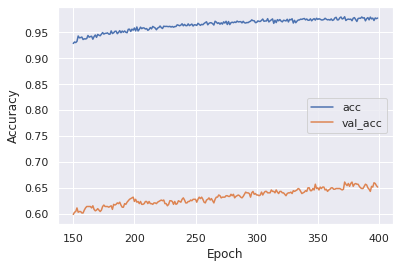

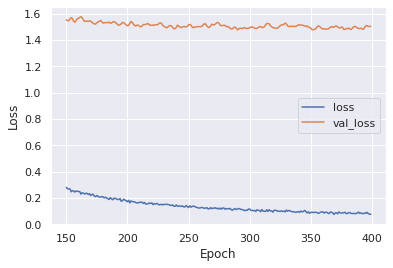

In [24]:
print(HPS.values)
history = base_model.history
epoch_start = 150

plt.figure()
capsize= 5
mean_acc = np.array(history['acc']).mean(axis=0)
std_acc = np.array(history['acc']).std(axis=0)
val_mean_acc = np.array(history['val_acc']).mean(axis=0)
val_std_acc = np.array(history['val_acc']).std(axis=0)
xticks = np.arange(epoch_start, len(mean_acc), 1)
plt.errorbar(xticks, mean_acc[epoch_start:], label='acc', capsize=capsize)
plt.errorbar(xticks, val_mean_acc[epoch_start:], label='val_acc', capsize=capsize)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
capsize= 5
mean_loss = np.array(history['loss']).mean(axis=0)
std_loss = np.array(history['loss']).std(axis=0)
val_mean_loss = np.array(history['val_loss']).mean(axis=0)
val_std_loss = np.array(history['val_loss']).std(axis=0)
xticks = np.arange(epoch_start, len(mean_loss), 1)
plt.errorbar(xticks, mean_loss[epoch_start:], label='loss', capsize=capsize)
plt.errorbar(xticks, val_mean_loss[epoch_start:], label='val_loss', capsize=capsize)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [25]:
%%time

tuner = kt.BayesianOptimization(
    objective=kt.Objective("val_loss", "min"),
    max_trials=10,
    hypermodel=EEGNet_SSVEP(nb_classes=num_targets, Chans=len(channels), Samples=timepoints_stimulus_duration),
    hyperparameters=HPS,
    overwrite=True,
)
tuner.search(X=X, y=y, verbose=0)
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

# Write YAML file
with open(optimal_hps_path, 'w', encoding='utf8') as outfile:
    hps_dict_out = {}
    for key, value in best_hps.values.items():
        hps_dict_out[key] = {'type':'fixed', 'value':value}
    yaml.dump(hps_dict_out, outfile, default_flow_style=False, allow_unicode=True)

1 / 10 fold
2 / 10 fold
3 / 10 fold
4 / 10 fold
5 / 10 fold
6 / 10 fold
7 / 10 fold
8 / 10 fold
9 / 10 fold
10 / 10 fold
1 / 10 fold
2 / 10 fold
3 / 10 fold
4 / 10 fold
5 / 10 fold
6 / 10 fold
7 / 10 fold
8 / 10 fold
9 / 10 fold
10 / 10 fold


2022-05-27 01:23:37.814790: I tensorflow/core/kernels/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x56209151ce50
2022-05-27 01:23:37.814911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-27 01:23:38.029987: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


1 / 10 fold
2 / 10 fold
3 / 10 fold
4 / 10 fold
5 / 10 fold
6 / 10 fold
7 / 10 fold
8 / 10 fold


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f32b223e790>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt



In [26]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
learningRate: 0.0007205588817774174
batchSize: 483
dropoutRate: 0.9470419669387854
F1: 107
D: 3
kernLength: 150
epochs: 400
patience: 400
Score: 2.1998734951019285
Trial summary
Hyperparameters:
learningRate: 0.0003657220393628534
batchSize: 99
dropoutRate: 0.7510108010151932
F1: 98
D: 2
kernLength: 150
epochs: 400
patience: 400
Score: 2.2842501640319823


## EEGNet + PCA

In [27]:
%%time

# Create dataset
num_channels = len(pc_channels)

trials = np.arange(0, num_trial_per_target)  # only using the subset of trials 
X = eeg_all_pca[trials]
y = np.empty([len(trial_all), 1])
for i, (freq, phase) in enumerate(trial_all):
    y[i] = target_idx_tab[(freq, phase)]
y = np.repeat(y, len(trials), axis=1).T  # shape: (trials, targets)

# flatten the trial and target dimensions
X = X.reshape([-1, num_channels, timepoints_stimulus_duration])[..., np.newaxis]
y = y.reshape([-1])

print(X.shape, y.shape)
# hyperparameters
epochs = 200
batch_size = 100
learning_rate = 1e-3
dropout_rate = 0.9

# # build model
num_folds = 10
kf = StratifiedKFold(n_splits=num_folds)
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f'{i + 1} / {num_folds} fold')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = EEGNet_SSVEP(num_targets, num_channels, timepoints_stimulus_duration, dropoutRate=dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

(720, 6, 1500, 1) (720,)
1 / 10 fold


TypeError: __init__() got an unexpected keyword argument 'dropoutRate'